In [73]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog

import PIL
import cv2
import pickle

from PIL import Image
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm

from IPython.display import display

# Load CIFAR-100
cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)

# Identify car-related class names
car_class_names = ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'streetcar', 'tractor']
car_indices = [cifar100.class_to_idx[name] for name in car_class_names]

# Output directory for car images
output_car_dir = './cifar100_cars'
os.makedirs(output_car_dir, exist_ok=True)

# Save only car images to directory
count = 0
for i in range(len(cifar100)):
    img, label = cifar100[i]
    if label in car_indices:
        img.save(os.path.join(output_car_dir, f"car_{count}.png"))
        count += 1

# Identify non-car class names
non_car_class_names = [class_name for class_name in cifar100.classes if class_name not in car_class_names]
non_car_indices = [cifar100.class_to_idx[name] for name in non_car_class_names]

# Output directory for non-car images
output_non_car_dir = './cifar100_non_cars'
os.makedirs(output_non_car_dir, exist_ok=True)

# Save 3000 random non-car images to directory
num_images = 3000
count_non_car = 0
sampled_images = []
non_car_indices_list = [i for i in range(len(cifar100)) if cifar100.targets[i] in non_car_indices]
random_indices = random.sample(non_car_indices_list, num_images)
for idx in random_indices:
    img, label = cifar100[idx]
    img.save(os.path.join(output_non_car_dir, f"non_car{count_non_car}.png"))
    count_non_car += 1

print(f"Saved {count} car images to {output_car_dir}")
print(f"Saved {count_non_car} non-car images to {output_non_car_dir}")

Saved 3000 car images to ./cifar100_cars
Saved 3000 non-car images to ./cifar100_non_cars


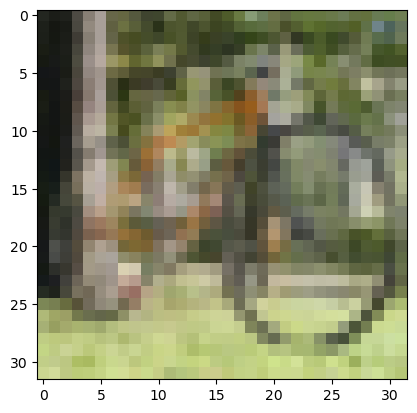

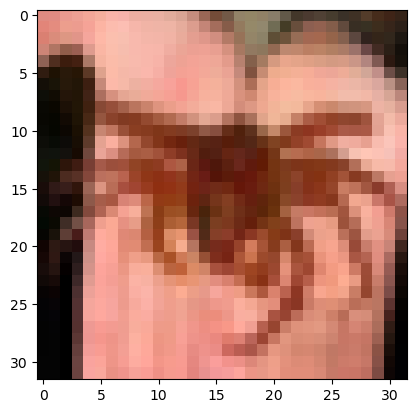

In [85]:
# Sample images
car_paths = glob(output_dir + "/*.png")
non_car_paths = glob(output_non_car_dir + "/*.png")

def process(filename: str=None) -> None:
    image = mpimg.imread(filename)
    plt.figure()
    plt.imshow(image)

for file in car_paths[:1]:
    process(file)

for file in non_car_paths[:1]:
    process(file)

(32, 32, 3)

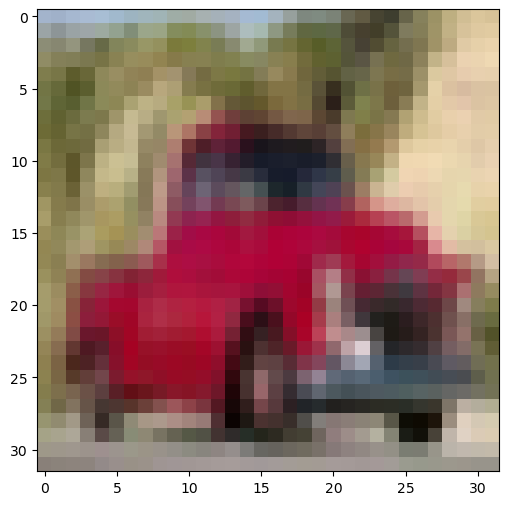

In [201]:
example_image = np.asarray(PIL.Image.open(car_paths[894]))
fig = plt.figure(figsize=(12, 6))
plt.imshow(example_image)
example_image.shape

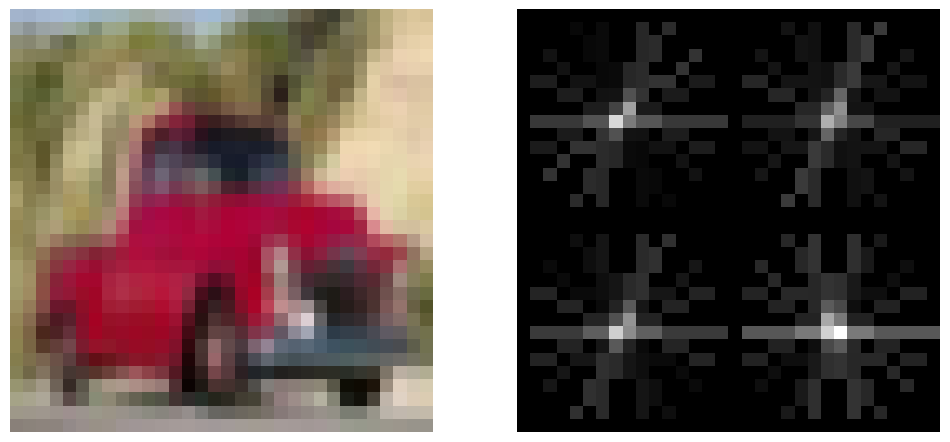

(36,)

In [205]:
from skimage.feature import hog

# Use HOG to focus on the shape of an image
hog_features, visualized = hog(image=example_image,
                               orientations=9,
                               pixels_per_cell=(16, 16),
                               cells_per_block=(2, 2),
                               visualize=True,
                               channel_axis=-1)

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(example_image)
plt.axis("off")
fig.add_subplot(1, 2, 2)
plt.imshow(visualized, cmap="gray")
plt.axis("off")
plt.show()

# hog_features is a vector
hog_features.shape

In [259]:
import time

pos_images = []
neg_images = []

pos_labels = np.ones(len(car_paths))
neg_labels = np.zeros(len(non_car_paths))

start = time.time()

# Extract features for positive images (cars)
for car_path in car_paths:
    img = np.asarray(PIL.Image.open(car_path))
    # We don't need RGB channels
    img = cv2.cvtColor(cv2.resize(img, (96,64)), cv2.COLOR_RGB2GRAY)
    img = hog(img, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2))
    pos_images.append(img)
    
# Extract features for negative images (non-cars)
for non_car_path in non_car_paths:
    img = np.asarray(PIL.Image.open(non_car_path))
    img = cv2.cvtColor(cv2.resize(img, (96,64)), cv2.COLOR_RGB2GRAY)
    img = hog(img, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2))
    neg_images.append(img)

# Stack positive and negative images
x = np.asarray(pos_images + neg_images)
y = np.asarray(list(pos_labels) + list(neg_labels))

processTime = round(time.time()-start, 2)
print(f"Reading images and extracting features has taken {processTime} seconds")

print("Shape of image set", x.shape)
print("Shape of labels", y.shape)

Reading images and extracting features has taken 166.96 seconds
Shape of image set (52132, 540)
Shape of labels (52132,)


In [261]:
# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(41705, 540)
(10427, 540)
(41705,)
(10427,)


In [263]:
from sklearn.svm import SVC

# Creating a SVC object
svc = SVC(kernel = 'rbf', verbose=True, random_state=42)

# Fit the training dataset
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)
print("Accuracy score of model is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100, 2))

[LibSVM]Accuracy score of model is  95.49


In [265]:
def test_prediction(img_path, true_label, svc):
    img = np.asarray(PIL.Image.open(img_path))
    img_gray = cv2.cvtColor(cv2.resize(img, (96, 64)), cv2.COLOR_RGB2GRAY)
    image, viz = hog(img_gray, orientations=9, pixels_per_cell=(16,16), cells_per_block=(2,2), visualize=True)

    x_tst = np.asarray(image)
    pred = svc.predict([x_tst])

    print("True label: ", true_label)
    plt.imshow(img)
    if pred[0] == 0.0:
        print("Prediction: Not car")
        
    elif pred[0] == 1.0:
        print("Prediction: Car")

True label:  Not car
Prediction: Not car


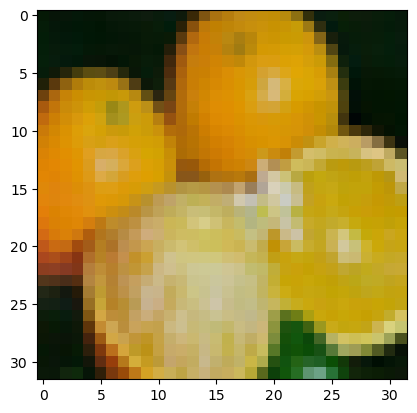

In [273]:
test_prediction(non_car_paths[479], "Not car", svc)

True label:  Car
Prediction: Car


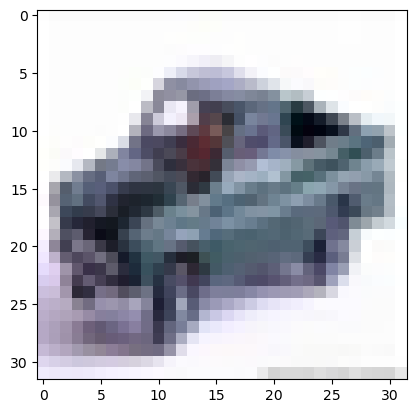

In [253]:
test_prediction(car_paths[1300], "Car", svc)

True label:  Car
Prediction: Car


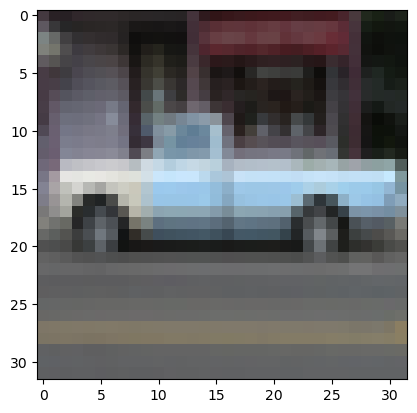

In [299]:
test_prediction(car_paths[10], "Car", svc)

True label:  Not car
Prediction: Not car


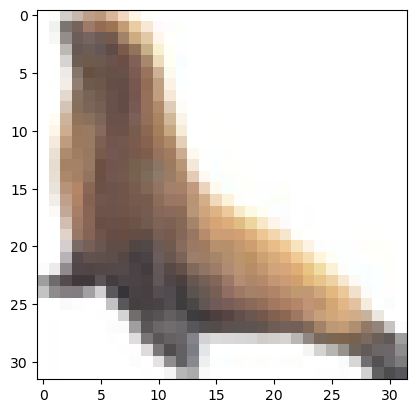

In [303]:
test_prediction(non_car_paths[-78], "Not car", svc)

In [307]:
# Testing for different values of Regularization

# Creating a SVC object
svc = SVC()
svc1 = SVC(C=0.01)
svc2 = SVC(C=100)

# Fitting the parameters
svc.fit(x_train,y_train)
svc1.fit(x_train,y_train)
svc2.fit(x_train,y_train)


y_pred = svc.predict(x_test)
print("Accuracy score of svc model is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100,2))

y_pred = svc1.predict(x_test)
print("Accuracy score of svc1 model with c=0.01 is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100,2))

y_pred = svc2.predict(x_test)
print("Accuracy score of svc2 model with c=100 is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100,2))

Accuracy score of svc model is  95.49
Accuracy score of svc1 model with c=0.01 is  94.29
Accuracy score of svc2 model with c=100 is  96.0


True label:  Not car
Prediction: Not car


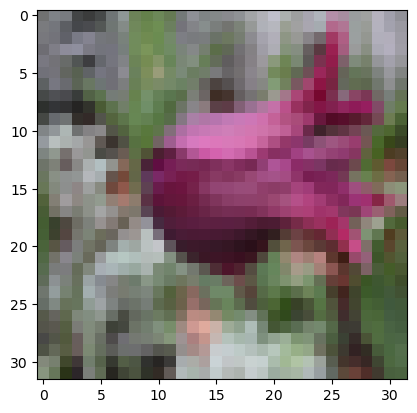

In [319]:
test_prediction(non_car_paths[90], "Not car", svc2)

True label:  Not car
Prediction: Not car


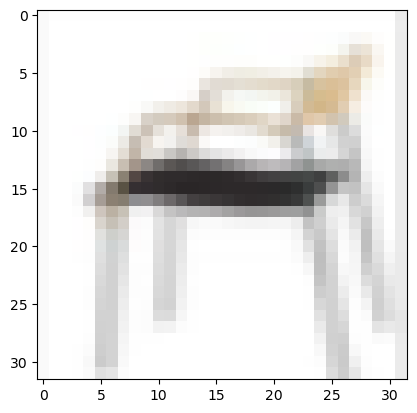

In [325]:
test_prediction(non_car_paths[2000], "Not car", svc2)

In [329]:
# Checking for overfitting

from sklearn.model_selection import cross_val_score

scores = cross_val_score(svc, x_test, y_test, cv=5)
scores1 = cross_val_score(svc1, x_test, y_test, cv=5)
scores2 = cross_val_score(svc2, x_test, y_test, cv=5)
print("Accuracy for svc with c=1.0: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Accuracy for svc with c=0.01: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))
print("Accuracy for svc with c=100: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

Accuracy for svc with c=1.0: 0.95 (+/- 0.00)
Accuracy for svc with c=0.01: 0.94 (+/- 0.00)
Accuracy for svc with c=100: 0.95 (+/- 0.01)
